In [1]:
# Standard library
import os
import sys
import warnings

# adjust path and suppress warnings
sys.path.insert(0, os.path.abspath('..'))
warnings.filterwarnings('ignore')

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import healpy as hp

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree

# Local
import util
import utils


In [2]:
size_ratio = 1
sub_width, sub_height = size_ratio*10/3, size_ratio*2.8
SMALL_SIZE = 9
MEDIUM_SIZE = 10
BIGGER_SIZE = 11

rc_default = {}
rc_default['font.family'] = 'serif'
rc_default['font.size'] = SMALL_SIZE
rc_default['axes.labelsize'] = MEDIUM_SIZE
rc_default['axes.labelweight'] = 'normal'
rc_default['axes.linewidth'] = 1.0
rc_default['axes.titlesize'] = MEDIUM_SIZE
rc_default['xtick.labelsize'] = SMALL_SIZE
rc_default['ytick.labelsize'] = SMALL_SIZE
rc_default['legend.fontsize'] = SMALL_SIZE
rc_default['figure.titlesize'] = BIGGER_SIZE
rc_default['lines.linewidth'] = 1
rc_default['lines.markersize'] = 4
rc_default['figure.figsize'] = (sub_width, sub_height)
rc_default['savefig.dpi'] = 300

# Latex related
rc_default['text.usetex'] = True
rc_default['mathtext.fontset'] = 'custom'
rc_default['mathtext.rm'] = 'Bitstream Vera Sans'
rc_default['mathtext.it'] = 'Bitstream Vera Sans:italic'
rc_default['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams.update(rc_default)
plt.style.use('tableau-colorblind10')

In [3]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [4]:
Legacy_path = "/home/ir-band1/1-research/1-4MOST/3-CRS/2-data/1-BG/desi_bg_nomaskbit_mask_4M_reduced_columns.fits"

In [5]:
Gaia_path = "/home/ir-band1/1-research/1-4MOST/3-CRS/2-data/8-Legacy_masks/gaia-mask-dr10_bg_foot.fits"

In [6]:
BG = Table.read(Legacy_path)

In [7]:
gaia = Table.read(Gaia_path)

In [8]:

BG

OBJID,RA,DEC,EBV,WISEMASK_W1,MASKBITS,isBG_4M,in_S8,in_DESI_DR1,mag_r,mag_z,mag_g,mag_i,mag_w1,isBG_4M_v2,desi_bgs_selection,galactic_cap,dr1_bg_mask
,deg,deg,,,,,,,,,,,,,,,
int32,float64,float64,float32,uint8,int32,bool,bool,bool,float32,float32,float32,float32,float32,bool,bool,bytes3,bool
419,157.0072201498557,-2.1468467554514508,0.044455066,0,0,False,False,True,19.254793,18.32375,20.694925,18.70724,17.812822,False,False,NGC,True
645,157.01433423838904,-2.2641702674806825,0.041389566,0,0,False,False,True,18.899773,18.50198,19.443045,18.654955,18.839195,False,True,NGC,True
838,157.0200785116195,-2.3639337222354797,0.039800275,0,0,False,False,True,18.914272,18.500732,19.573341,18.65716,19.303652,False,True,NGC,True
1164,157.02686834051426,-2.159646811120505,0.043790996,0,0,True,False,True,18.984041,18.54076,19.72362,18.707792,18.666428,False,True,NGC,True
1219,157.0281576193182,-2.272059179114334,0.041178815,0,0,True,False,True,18.530964,17.854332,19.707085,18.141018,17.93635,True,True,NGC,True
1576,157.03549970264152,-2.270895163249637,0.041185517,0,0,True,False,True,18.15484,17.266401,19.582981,17.617146,16.646183,True,True,NGC,True
1690,157.03851793006055,-2.226166286097986,0.042040892,0,0,False,False,True,19.321472,18.318218,21.130793,18.684061,17.62561,False,False,NGC,True
1940,157.04382620147746,-2.1518624340791046,0.04378916,0,0,False,False,True,19.178022,18.516327,20.12455,18.78125,18.564873,False,True,NGC,True


In [9]:
ramin, ramax = 0, 80
decmin, decmax = -60, -30

In [10]:
BG = BG[(BG['RA'] > ramin) & (BG['RA'] < ramax)]
BG = BG[(BG['DEC'] > decmin) & (BG['DEC'] < decmax)]
gaia = gaia[(gaia['RA'] > ramin) & (gaia['RA'] < ramax)]
gaia = gaia[(gaia['DEC'] > decmin) & (gaia['DEC'] < decmax)]

In [11]:
BG.keep_columns(['RA', 'DEC', 'in_S8', 'MASKBITS'])

In [12]:
BG = BG.to_pandas()

In [13]:
BG = BG[BG['in_S8']]

In [14]:
BG

,RA,DEC,MASKBITS,in_S8
0,61.864164,-48.102204,0,True
1,61.873766,-48.022694,0,True
2,61.877416,-47.943971,65536,True
3,61.885109,-47.882649,65536,True
4,61.886476,-47.898439,65536,True
...,...,...,...,...
1381146,60.043883,-54.052211,0,True
1381147,60.084699,-53.921420,0,True
1381148,60.086530,-53.983893,0,True
1381149,60.105911,-53.975696,0,True


In [15]:
gaia = gaia.to_pandas()

In [16]:
gaia

,RA,DEC,G,R_medium_arcsec,R_bright_arcsec,isbright,ismedium
0,76.932832,-30.102444,10.397454,0.014107,0.007054,True,True
1,77.145991,-30.029893,10.890274,0.011969,0.005984,True,True
2,77.001224,-30.122458,13.897633,0.004389,0.002194,False,True
3,77.154719,-30.123215,14.425462,0.003680,0.001840,False,True
4,77.104302,-30.004057,14.723269,0.003332,0.001666,False,True
...,...,...,...,...,...,...,...
694882,59.371291,-59.921562,15.111728,0.002927,0.001463,False,True
694883,59.523366,-59.951909,15.334808,0.002717,0.001359,False,True
694884,59.380164,-59.982112,15.358424,0.002696,0.001348,False,True
694885,59.481560,-59.908270,15.469630,0.002598,0.001299,False,True


In [17]:
sel_1 = ~(BG['MASKBITS'] & 2**1 > 0)
sel_11 = ~(BG['MASKBITS'] & 2**11 > 0)
sel = sel_1 & sel_11

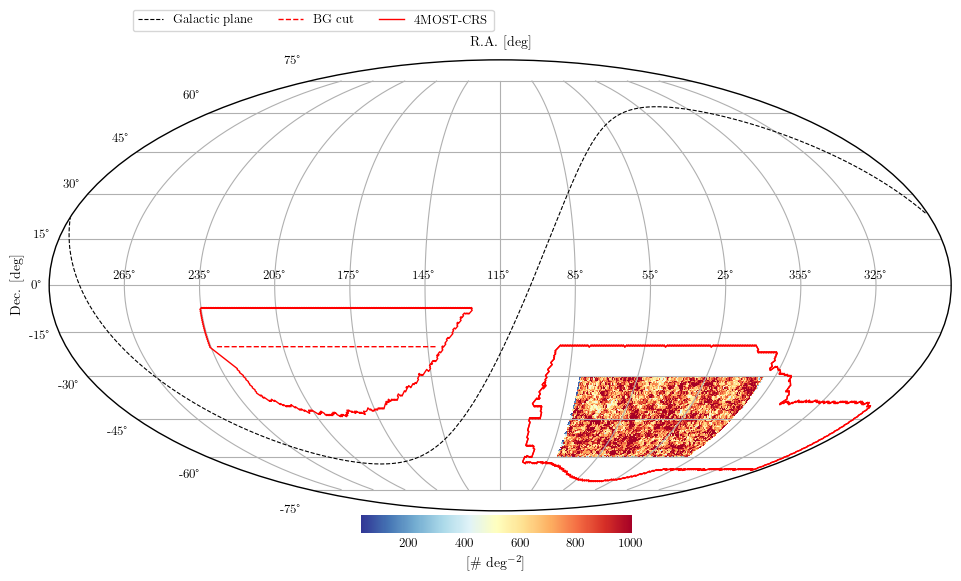

In [18]:
hpmap = utils.create_hp_map(BG['RA'], BG['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=1000, fourmost_footprint=True)

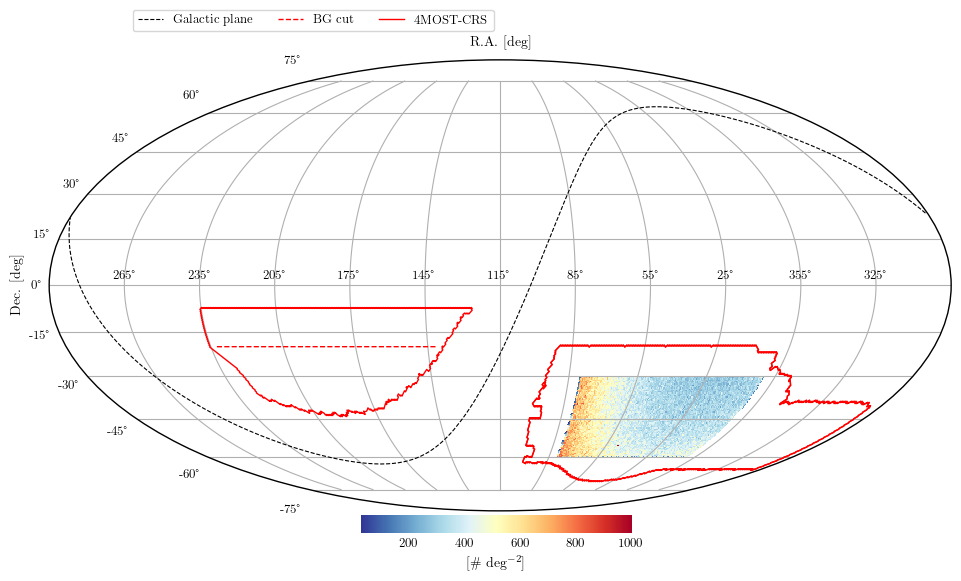

In [19]:
hpmap = utils.create_hp_map(gaia['RA'], gaia['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=1000, fourmost_footprint=True)

In [21]:


# 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
bright = gaia[gaia['G'] <= 13]
stars = SkyCoord(ra=bright['RA'].values * u.deg,
                 dec=bright['DEC'].values * u.deg)

# 3. Make a SkyCoord for your BG objects
cats  = SkyCoord(ra=BG['RA'].values * u.deg,
                 dec=BG['DEC'].values * u.deg)

# 4. Cross-match each BG to its nearest bright star
idx, sep2d, _ = stars.match_to_catalog_sky(cats)

# 5. Compute ΔRA, ΔDec (in the tangent-plane sense)
#    – we want small-angle approx: ΔRA_c = (RA_BG − RA_star)⋅cos(Dec_star)
ra_bg  = cats[idx].ra.rad
dec_bg = cats[idx].dec.rad
ra_st  = stars.ra.rad
dec_st = stars.dec.rad

dRA_c  = (ra_bg  - ra_st ) * np.cos(dec_st)
dDec   =  dec_bg - dec_st

# 6. Define the bright-star masking radius R_BS(m)
#    – Zarrouk et al. use a lookup or fit: e.g. RBS = f(mag)
#      here’s a toy linear example; you’ll need the real curve:
R_BS = 10**(0.2 * (13 - bright['G'].values[idx]))  # in arcsec, say

# 7. Scale your separations by that radius
x = dRA_c  * 3600. / R_BS   # now dimensionless ΔRA/RBS
y = dDec   * 3600. / R_BS   # dimensionless ΔDec/RBS

# 8. Make a 2D histogram of (x,y)
nbins = 200
H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
#  how to turn that into a density *ratio* η/η̄ ?
#  – compute the mean density in an annulus 1.1<R<4:
Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
XX, YY = np.meshgrid(Xc,Yc)
R = np.sqrt(XX**2 + YY**2)
mask = (R>1.1) & (R<4)
eta_mean = H[mask].mean()
density_ratio = H / eta_mean

# 9. Plot
fig, ax = plt.subplots(figsize=(6,6))
pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                    cmap='RdBu_r', vmin=-4, vmax=+4)
fig.colorbar(pcm, label=r'$\log_2(\eta/\bar\eta)$')

# 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
for rad, col in [(1,'k'), (2,'r')]:
    circ = Circle((0,0), radius=rad, fill=False, ls='-', lw=2, ec=col)
    ax.add_patch(circ)

ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
ax.axhline(0, color='k', lw=1)
ax.axvline(0, color='k', lw=1)
ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')

plt.show()


IndexError: index 1235255 is out of bounds for axis 0 with size 110869

In [22]:
# --- placeholder functions: replace with the real DR8/DR9 formulas ---
def mask_radius_DR9(g):
    # DR9 bright‐star mask radius [arcsec] as a function of G-mag
    # e.g. piecewise interpolation from Legacy Surveys DR9 prescription.
    # Here’s a toy example:
    return  10**(0.2*(13 - g))

def mask_radius_DR8(g):
    # DR8 bright‐star mask radius [arcsec] as a function of G-mag
    # e.g. a different piecewise curve published for DR8.
    # Here’s a toy example that’s ~1.7× larger than DR9:
    return 2 * mask_radius_DR9(g)
    
def mask_radius_for_mag(mag):
    # Returns a masking radius in degrees for a star of the given magnitude.
    # Used for Tycho-2 and Gaia stars.

    # This is in degrees, and is from Rongpu in the thread [decam-chatter 12099].
    return 0.5*1630. * 1.396**(-mag)
# --- build BG SkyCoord once ---
cats = SkyCoord(ra=BG['RA'].values*u.deg,
                dec=BG['DEC'].values*u.deg)

In [23]:
# --- your existing bins & setup ---
mag_bins = [(8, 12), (12, 13), (13, 15), (15, 16)]
nbins    = 150
r_extent = 3.0
annulus  = (1.1, 3.0)
dr       = 1

# --- placeholder functions: replace with the real DR8/DR9 formulas ---
def mask_radius_DR9(g):
    # DR9 bright‐star mask radius [arcsec] as a function of G-mag
    # e.g. piecewise interpolation from Legacy Surveys DR9 prescription.
    # Here’s a toy example:
    return  10**(0.2*(13 - g))

def mask_radius_DR8(g):
    # DR8 bright‐star mask radius [arcsec] as a function of G-mag
    # e.g. a different piecewise curve published for DR8.
    # Here’s a toy example that’s ~1.7× larger than DR9:
    return 2 * mask_radius_DR9(g)

def mask_radius_for_mag(mag):
    # Returns a masking radius in degrees for a star of the given magnitude.
    # Used for Tycho-2 and Gaia stars.

    # This is in degrees, and is from Rongpu in the thread [decam-chatter 12099].
    return 0.5*1630. * 1.396**(-mag)
# --- build BG SkyCoord once ---
cats = SkyCoord(ra=BG['RA'].values*u.deg,
                dec=BG['DEC'].values*u.deg)

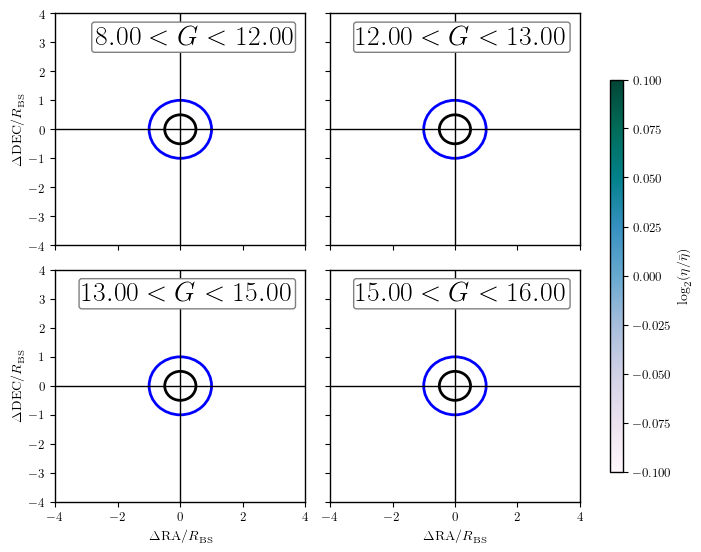

In [24]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

axes = axes.flatten()

i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars = SkyCoord(ra=bright['RA'].values * u.deg,
                    dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=BG['RA'].values * u.deg,
                    dec=BG['DEC'].values * u.deg)

    # 4. Cross-match each BG to its nearest bright star
    idx, sep2d, _ = stars.match_to_catalog_sky(cats)

    # 5. Compute ΔRA, ΔDec (in the tangent-plane sense)
    #    – we want small-angle approx: ΔRA_c = (RA_BG − RA_star)⋅cos(Dec_star)
    ra_bg  = cats[idx].ra.rad
    dec_bg = cats[idx].dec.rad
    ra_st  = stars.ra.rad
    dec_st = stars.dec.rad

    dRA_c  = (ra_bg  - ra_st ) * np.cos(dec_st)
    dDec   =  dec_bg - dec_st

    # 6. Define the bright-star masking radius R_BS(m)
    #    – Zarrouk et al. use a lookup or fit: e.g. RBS = f(mag)
    #      here’s a toy linear example; you’ll need the real curve:
    # R_BS = 10**(0.2 * (13 - bright['G'].values))  # in arcsec, say
    R_BS = 1630. * 1.396**(- bright['G'].values)
    R_BS_max = max(R_BS)
    # 7. Scale your separations by that radius
    x = dRA_c  * 3600./R_BS    # now dimensionless ΔRA/RBS
    y = dDec   * 3600./R_BS # dimensionless ΔDec/RBS

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>1.1) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn')


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    for rad, col in [(0.5,'k'), (1,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='-', lw=2, ec=col)
        ax.add_patch(circ)
    ax.text (0.95, 0.95, fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
             transform=ax.transAxes, fontsize=20, verticalalignment='top',
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=1, edgecolor='gray', boxstyle='round,pad=0.1'))
    
    # ax.set_xlim(-4,4)
    # ax.set_ylim(-4,4)
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
plt.tight_layout(rect=[0,0,0.9,1])
plt.show()



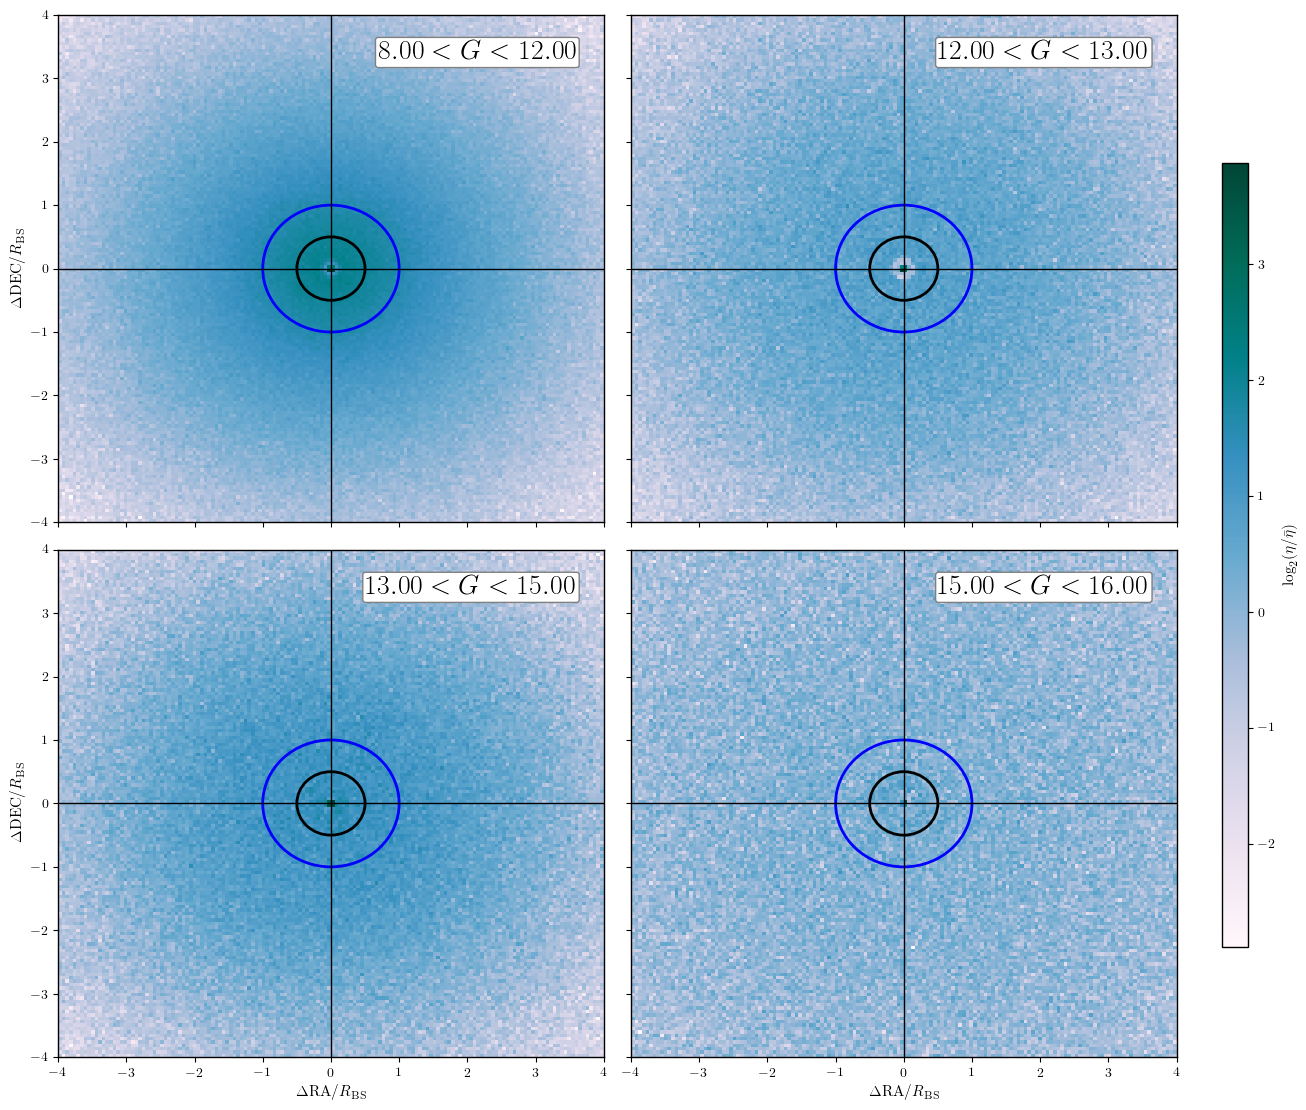

In [26]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

axes = axes.flatten()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    # stars = SkyCoord(ra=bright['RA'].values * u.deg,
    #                 dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=BG['RA'].values * u.deg,
                    dec=BG['DEC'].values * u.deg)

    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars  = SkyCoord(ra=bright['RA'].values*u.deg,
                      dec=bright['DEC'].values*u.deg)

    # match & compute offsets
    idx, _, _     = cats.match_to_catalog_sky(stars)
    ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
    ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
    dRAc = (ra_bg - ra_st)*np.cos(dec_st)
    dDec = dec_bg - dec_st

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[idx]
    R9_arcsec   = mask_radius_DR9(mags_at_idx)
    x = dRAc * 3600.0 / R9_arcsec
    y = dDec * 3600.0 / R9_arcsec

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>1.1) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn')


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    for rad, col in [(0.5,'k'), (1,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='-', lw=2, ec=col)
        ax.add_patch(circ)
    ax.text (0.95, 0.95, fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
             transform=ax.transAxes, fontsize=20, verticalalignment='top',
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=1, edgecolor='gray', boxstyle='round,pad=0.1'))
    
    # ax.set_xlim(-4,4)
    # ax.set_ylim(-4,4)
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
plt.tight_layout(rect=[0,0,0.9,1])
plt.show()



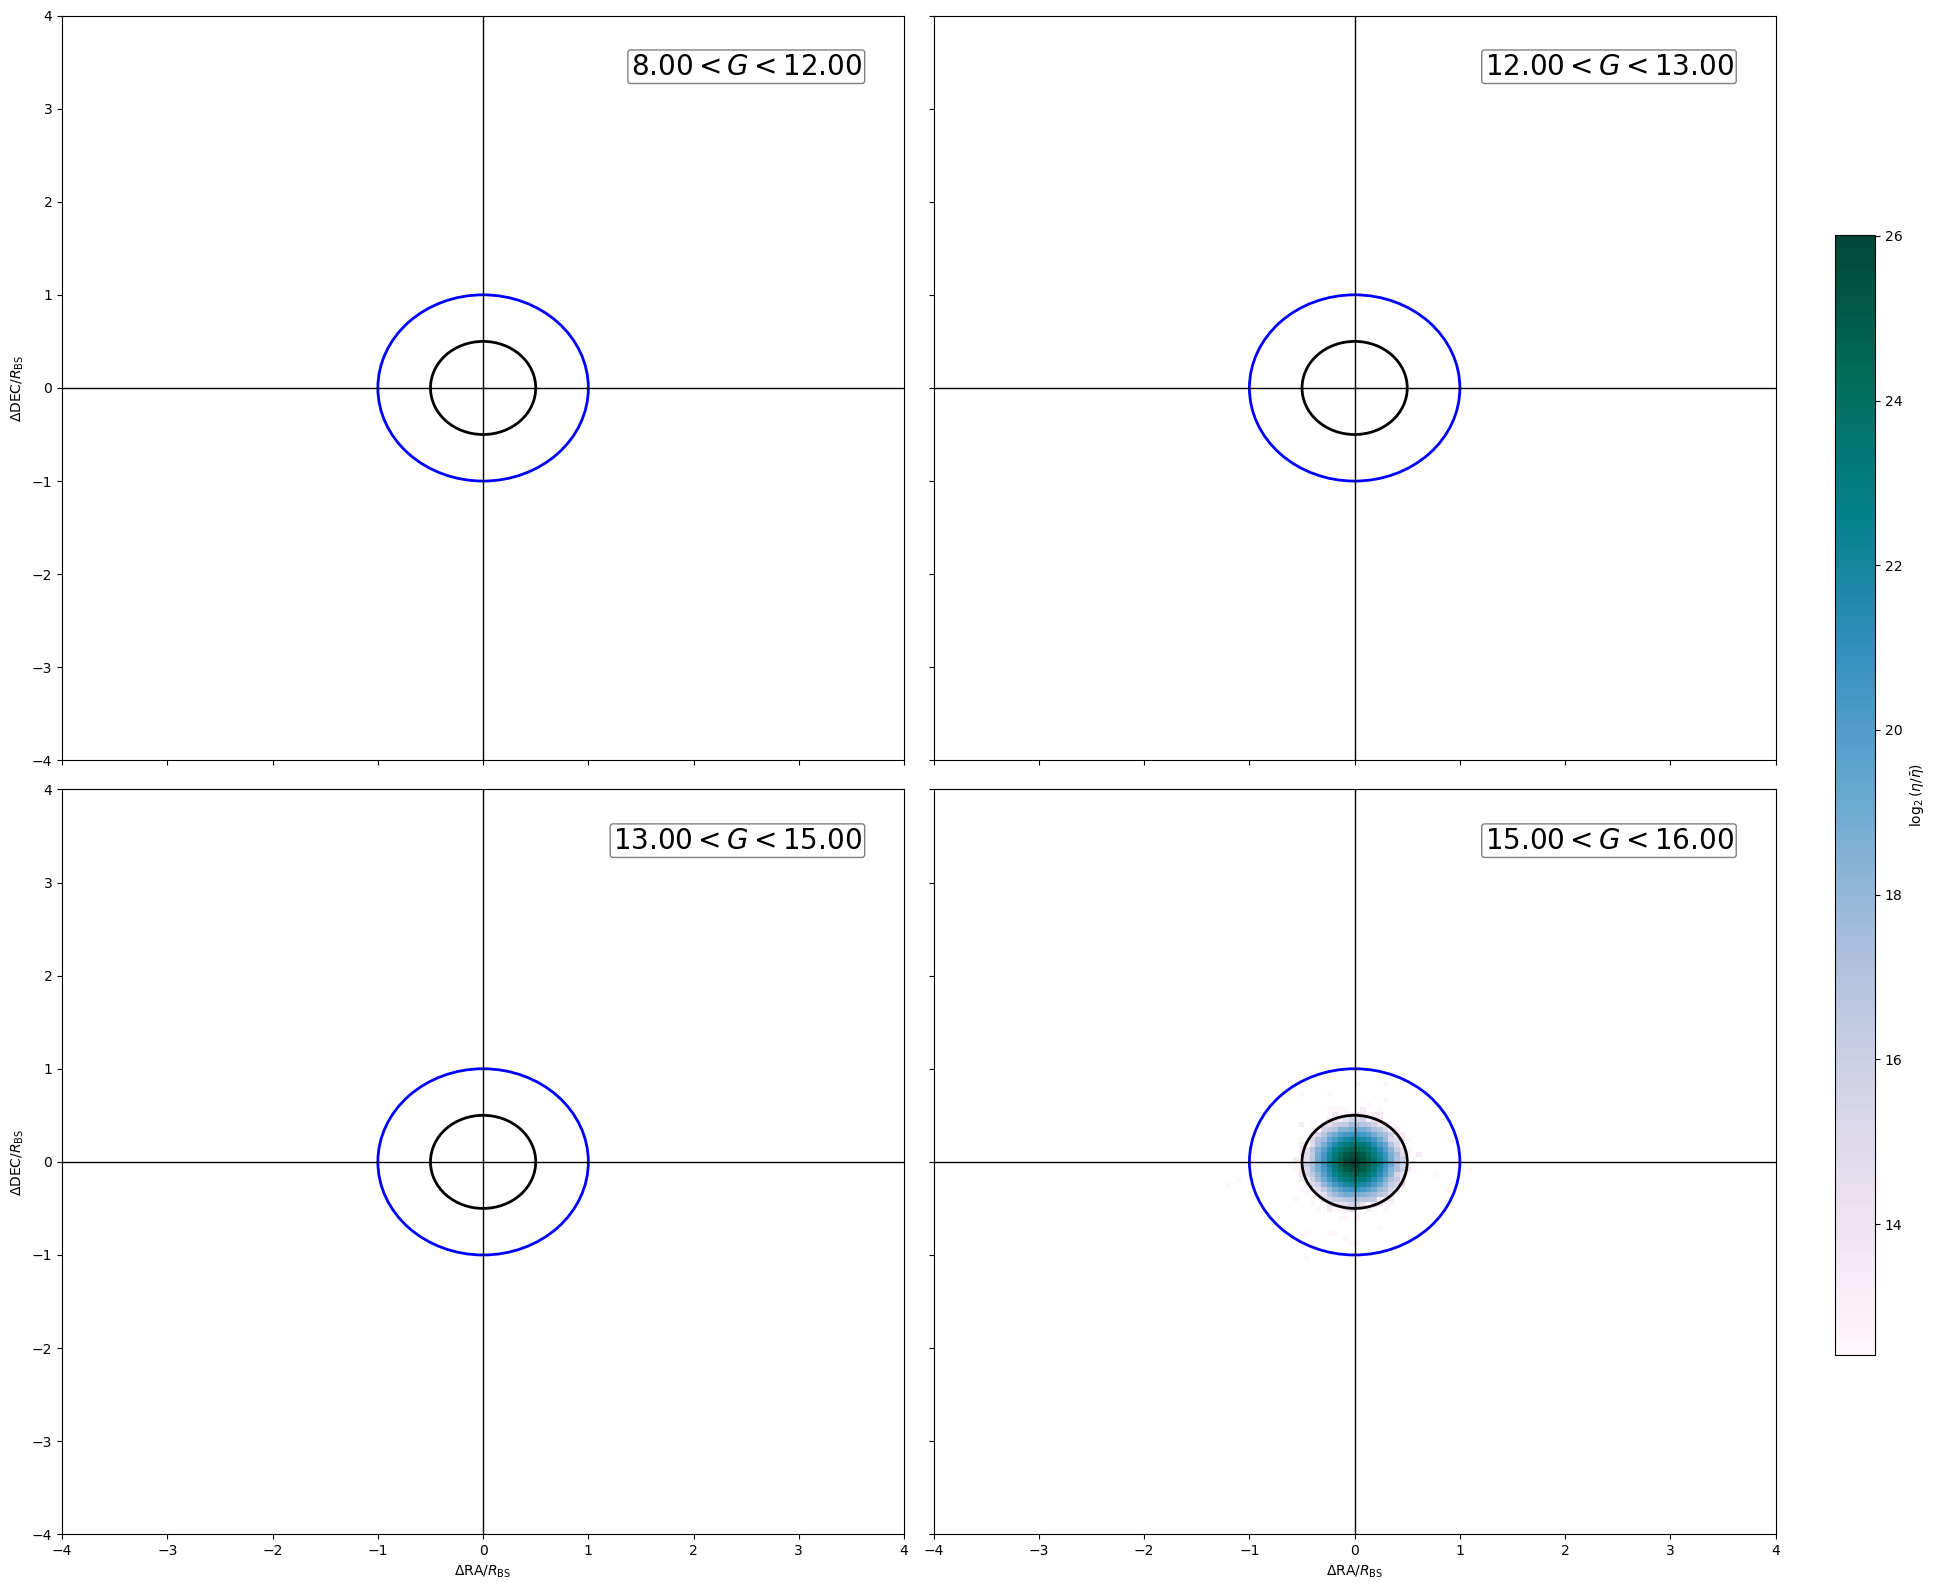

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16), sharex=True, sharey=True)

axes = axes.flatten()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars = SkyCoord(ra=bright['RA'].values * u.deg,
                    dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=BG[sel_1]['RA'].values * u.deg,
                    dec=BG[sel_1]['DEC'].values * u.deg)

    # 4. Cross-match each BG to its nearest bright star
    idx, sep2d, _ = stars.match_to_catalog_sky(cats)

    # 5. Compute ΔRA, ΔDec (in the tangent-plane sense)
    #    – we want small-angle approx: ΔRA_c = (RA_BG − RA_star)⋅cos(Dec_star)
    ra_bg  = cats[idx].ra.rad
    dec_bg = cats[idx].dec.rad
    ra_st  = stars.ra.rad
    dec_st = stars.dec.rad

    dRA_c  = (ra_bg  - ra_st ) * np.cos(dec_st)
    dDec   =  dec_bg - dec_st

    # 6. Define the bright-star masking radius R_BS(m)
    #    – Zarrouk et al. use a lookup or fit: e.g. RBS = f(mag)
    #      here’s a toy linear example; you’ll need the real curve:
    # R_BS = 10**(0.2 * (13 - bright['G'].values))  # in arcsec, say
    R_BS = 1630. * 1.396**(- bright['G'].values)
    R_BS_max = max(R_BS)
    # 7. Scale your separations by that radius
    x = dRA_c  * 3600./R_BS    # now dimensionless ΔRA/RBS
    y = dDec   * 3600./R_BS # dimensionless ΔDec/RBS

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>1.1) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn')


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    for rad, col in [(0.5,'k'), (1,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='-', lw=2, ec=col)
        ax.add_patch(circ)
    ax.text (0.95, 0.95, fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
             transform=ax.transAxes, fontsize=20, verticalalignment='top',
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=1, edgecolor='gray', boxstyle='round,pad=0.1'))
    
    # ax.set_xlim(-4,4)
    # ax.set_ylim(-4,4)
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
plt.tight_layout(rect=[0,0,0.9,1])
plt.show()



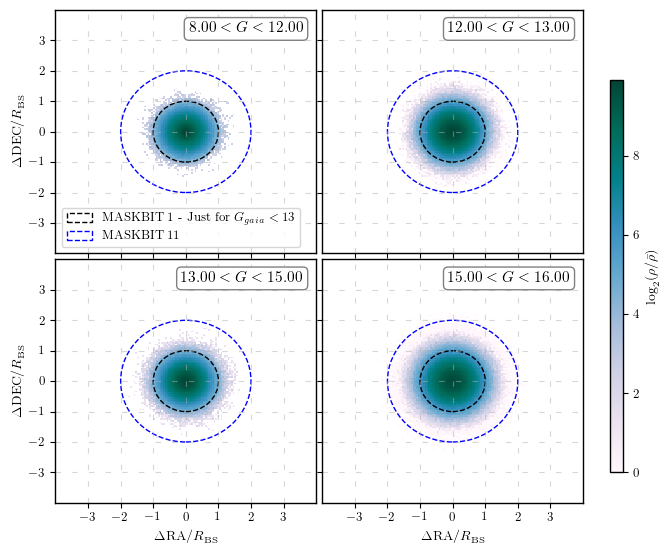

In [105]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.01, wspace=0.01)

axes = axes.flatten()

i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    # stars = SkyCoord(ra=bright['RA'].values * u.deg,
    #                 dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=BG['RA'].values * u.deg,
                    dec=BG['DEC'].values * u.deg)

    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars  = SkyCoord(ra=bright['RA'].values*u.deg,
                      dec=bright['DEC'].values*u.deg)

    # match & compute offsets
    idx, _, _     = cats.match_to_catalog_sky(stars)
    ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
    ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
    dRAc = (ra_bg - ra_st)*np.cos(dec_st)
    dDec = dec_bg - dec_st

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[idx]
    R9_arcsec   = mask_radius_DR9(mags_at_idx)
    R_BS = 0.5 * 1630. * 1.396**(-bright['G'].values[idx])
    R_BS_max = max(R_BS)

    x = dRAc * 3600.0 / R_BS
    y = dDec * 3600.0 / R_BS

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>1.1) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn', vmin=0)


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']
    for rad, col in [(1,'k'), (2,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        ax.add_patch(circ)
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        fontsize=BIGGER_SIZE,
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cax, label=r'$\log_2(\rho/\bar\rho)$')

plt.tight_layout(rect=[0,0,0.9,1], h_pad=0.1, w_pad=0.1)
plt.savefig('gaia_mask_BG.png', dpi=450, bbox_inches='tight')
plt.savefig('gaia_mask_BG.pdf', dpi=450, bbox_inches='tight')
plt.show()



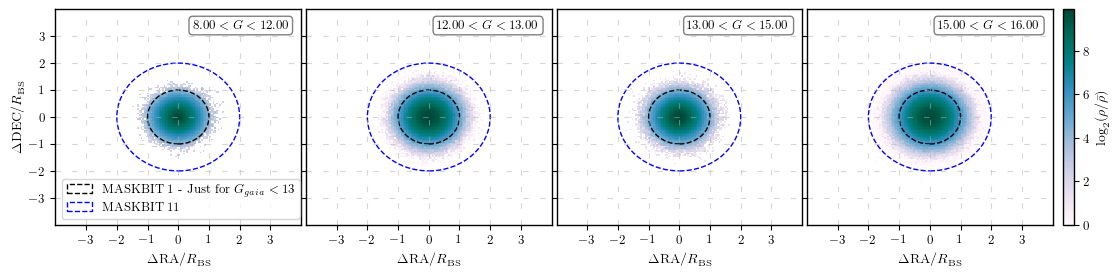

In [101]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten()

i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    # stars = SkyCoord(ra=bright['RA'].values * u.deg,
    #                 dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=BG['RA'].values * u.deg,
                    dec=BG['DEC'].values * u.deg)

    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars  = SkyCoord(ra=bright['RA'].values*u.deg,
                      dec=bright['DEC'].values*u.deg)

    # match & compute offsets
    idx, _, _     = cats.match_to_catalog_sky(stars)
    ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
    ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
    dRAc = (ra_bg - ra_st)*np.cos(dec_st)
    dDec = dec_bg - dec_st

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[idx]
    R9_arcsec   = mask_radius_DR9(mags_at_idx)
    R_BS = 0.5 * 1630. * 1.396**(-bright['G'].values[idx])
    R_BS_max = max(R_BS)

    x = dRAc * 3600.0 / R_BS
    y = dDec * 3600.0 / R_BS

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>1.1) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn', vmin=0)


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']
    for rad, col in [(1,'k'), (2,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        ax.add_patch(circ)
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
cbar = fig.colorbar(pcm, ax=axes, fraction=0.025, pad=0.01)
cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
# plt.tight_layout(rect=[0,0,0.9,1])
plt.savefig('gaia_mask_BG_4x1.png', dpi=400, bbox_inches='tight')
plt.savefig('gaia_mask_BG_4x1.pdf', dpi=400, bbox_inches='tight')


plt.show()



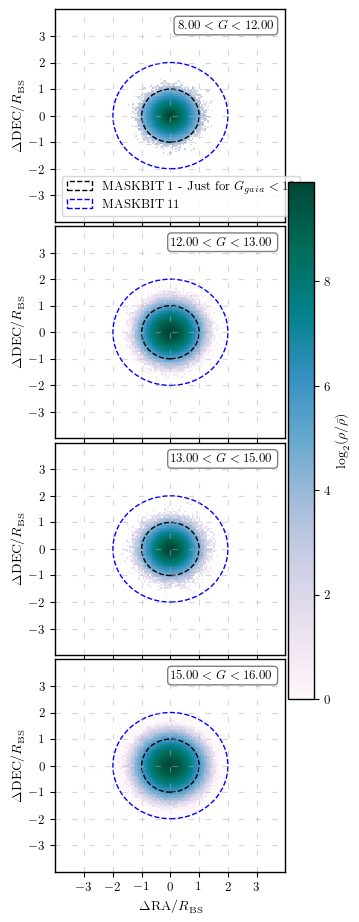

In [32]:
nrows = 4
ncols = 1
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten()

i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    # stars = SkyCoord(ra=bright['RA'].values * u.deg,
    #                 dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=BG['RA'].values * u.deg,
                    dec=BG['DEC'].values * u.deg)

    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars  = SkyCoord(ra=bright['RA'].values*u.deg,
                      dec=bright['DEC'].values*u.deg)

    # match & compute offsets
    idx, _, _     = cats.match_to_catalog_sky(stars)
    ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
    ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
    dRAc = (ra_bg - ra_st)*np.cos(dec_st)
    dDec = dec_bg - dec_st

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[idx]
    R9_arcsec   = mask_radius_DR9(mags_at_idx)
    R_BS = 0.5 * 1630. * 1.396**(-bright['G'].values[idx])
    R_BS_max = max(R_BS)

    x = dRAc * 3600.0 / R_BS
    y = dDec * 3600.0 / R_BS

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>1.1) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn', vmin=0)


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']
    for rad, col in [(1,'k'), (2,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        ax.add_patch(circ)
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[1].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[3].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')

# axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
cbar = fig.colorbar(pcm, ax=axes, fraction=0.1, pad=0.01)

cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
# plt.tight_layout(rect=[0,0,0.9,1])
# plt.savefig('gaia_mask_BG_1x4.png', dpi=400, bbox_inches='tight')
# plt.savefig('gaia_mask_BG_1x5.pdf', dpi=400, bbox_inches='tight')


plt.show()



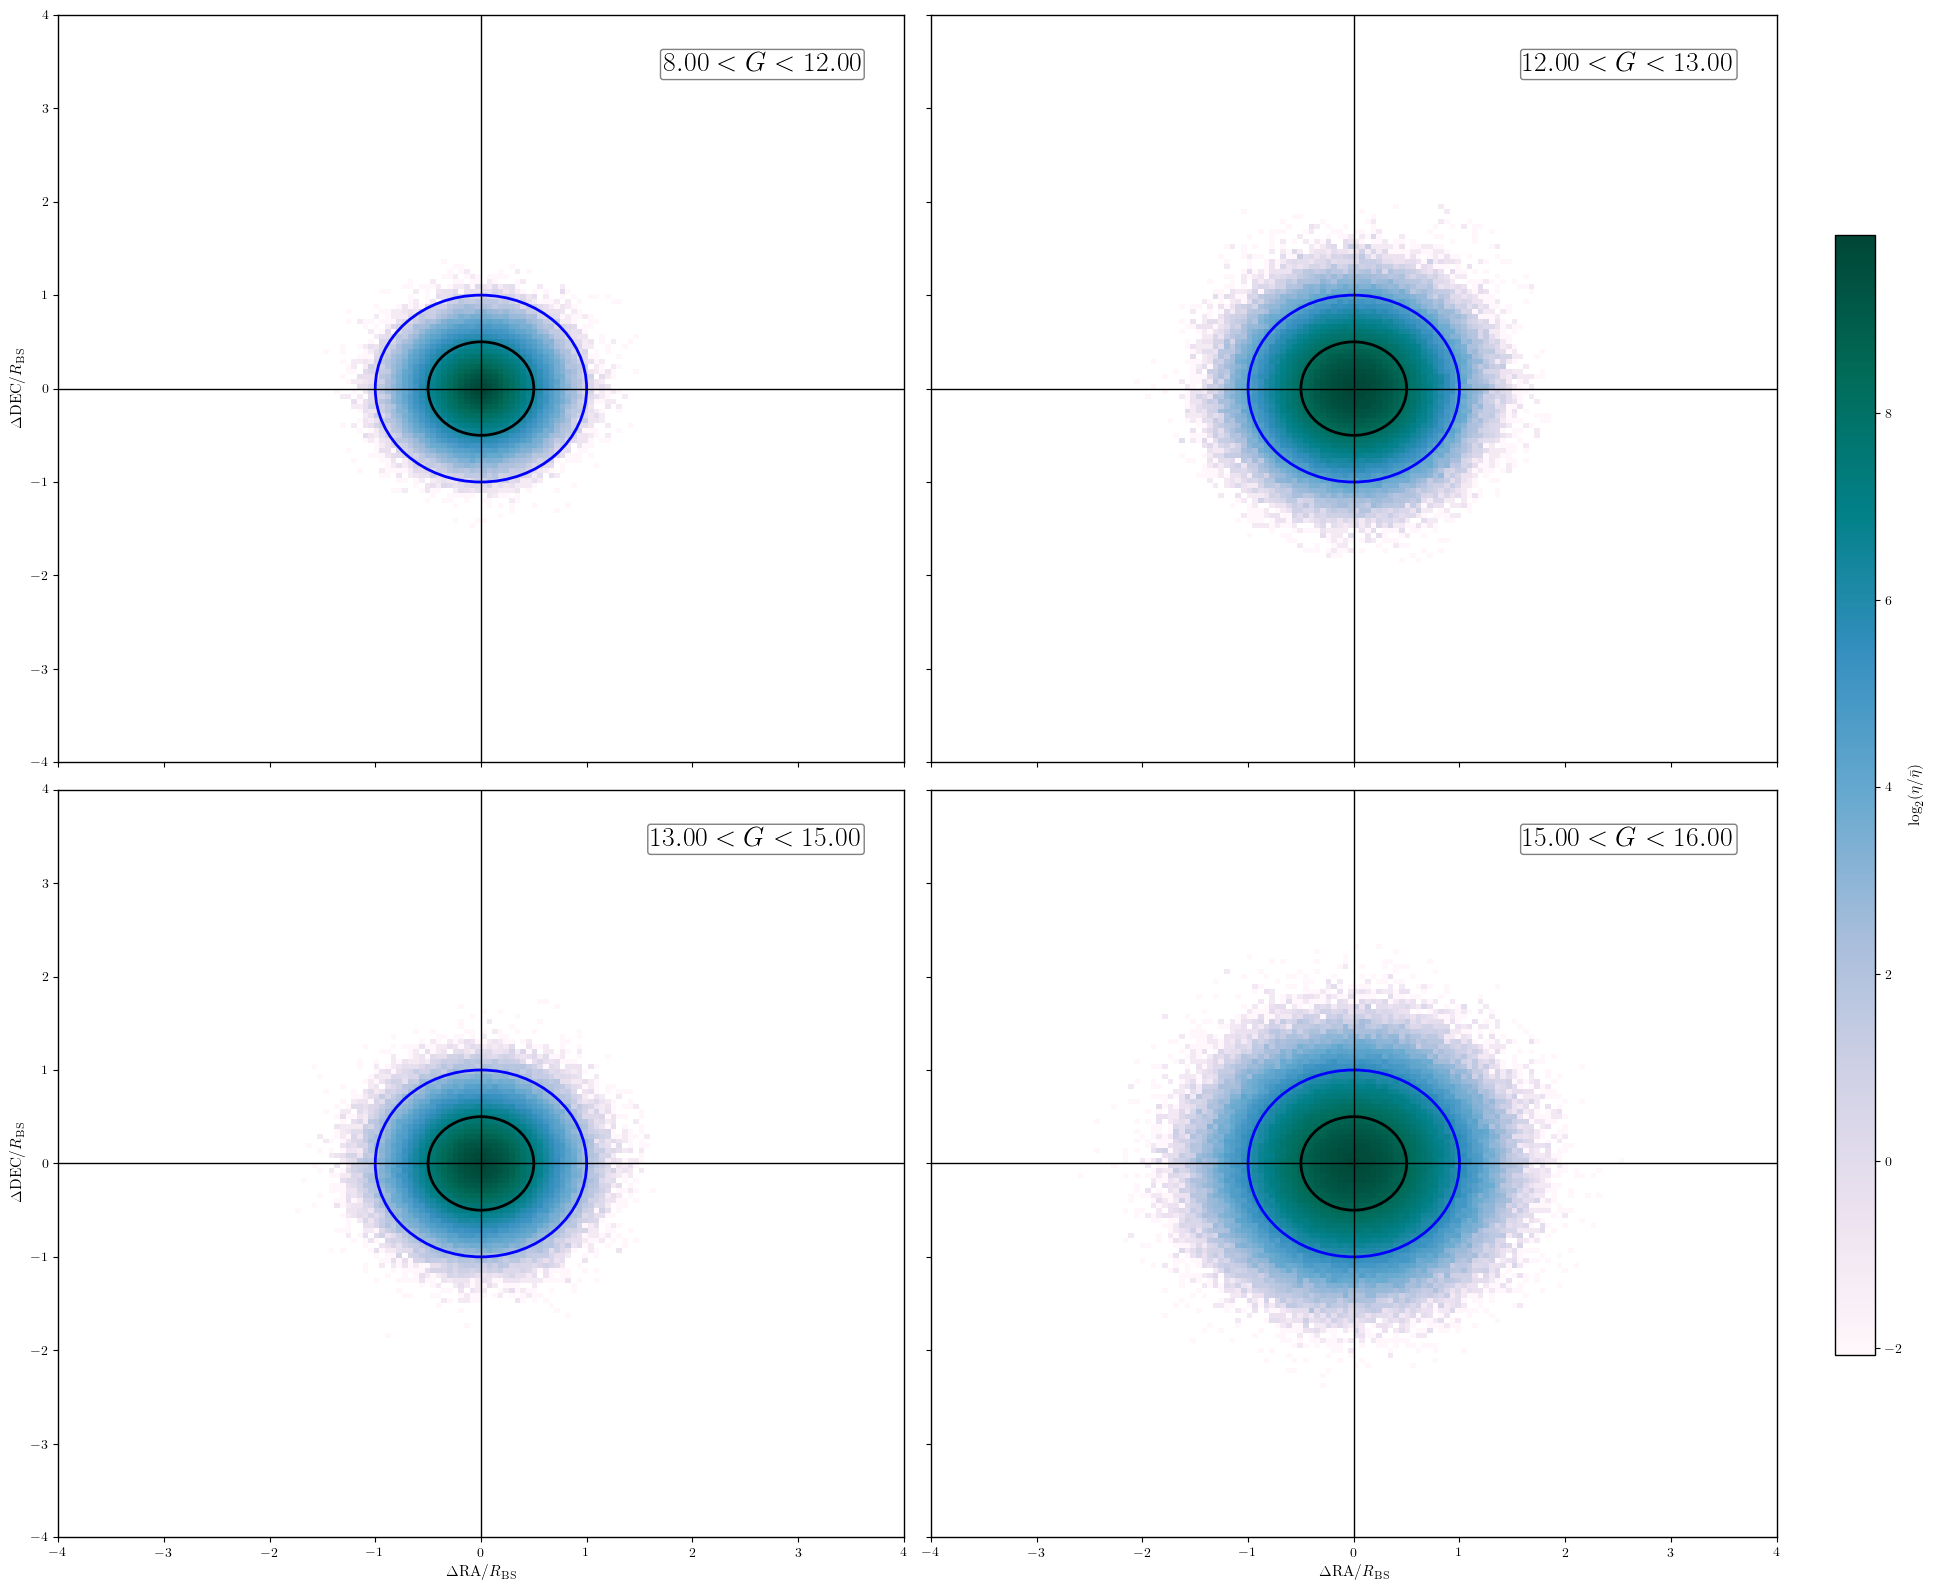

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16), sharex=True, sharey=True)

axes = axes.flatten()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    # stars = SkyCoord(ra=bright['RA'].values * u.deg,
    #                 dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=BG['RA'].values * u.deg,
                    dec=BG['DEC'].values * u.deg)

    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars  = SkyCoord(ra=bright['RA'].values*u.deg,
                      dec=bright['DEC'].values*u.deg)

    # match & compute offsets
    idx, _, _     = cats.match_to_catalog_sky(stars)
    ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
    ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
    dRAc = (ra_bg - ra_st)*np.cos(dec_st)
    dDec = dec_bg - dec_st

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[idx]
    R9_arcsec   = mask_radius_DR9(mags_at_idx)
    R_BS = 0.5 * 1630. * 1.396**(-bright['G'].values[idx])
    R_BS_max = max(R_BS)

    x = dRAc * 3600.0 / R_BS
    y = dDec * 3600.0 / R_BS

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>1.1) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn')


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    for rad, col in [(0.5,'k'), (1,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='-', lw=2, ec=col)
        ax.add_patch(circ)
    ax.text (0.95, 0.95, fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
             transform=ax.transAxes, fontsize=20, verticalalignment='top',
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=1, edgecolor='gray', boxstyle='round,pad=0.1'))
    
    # ax.set_xlim(-4,4)
    # ax.set_ylim(-4,4)
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
plt.tight_layout(rect=[0,0,0.9,1])
plt.show()



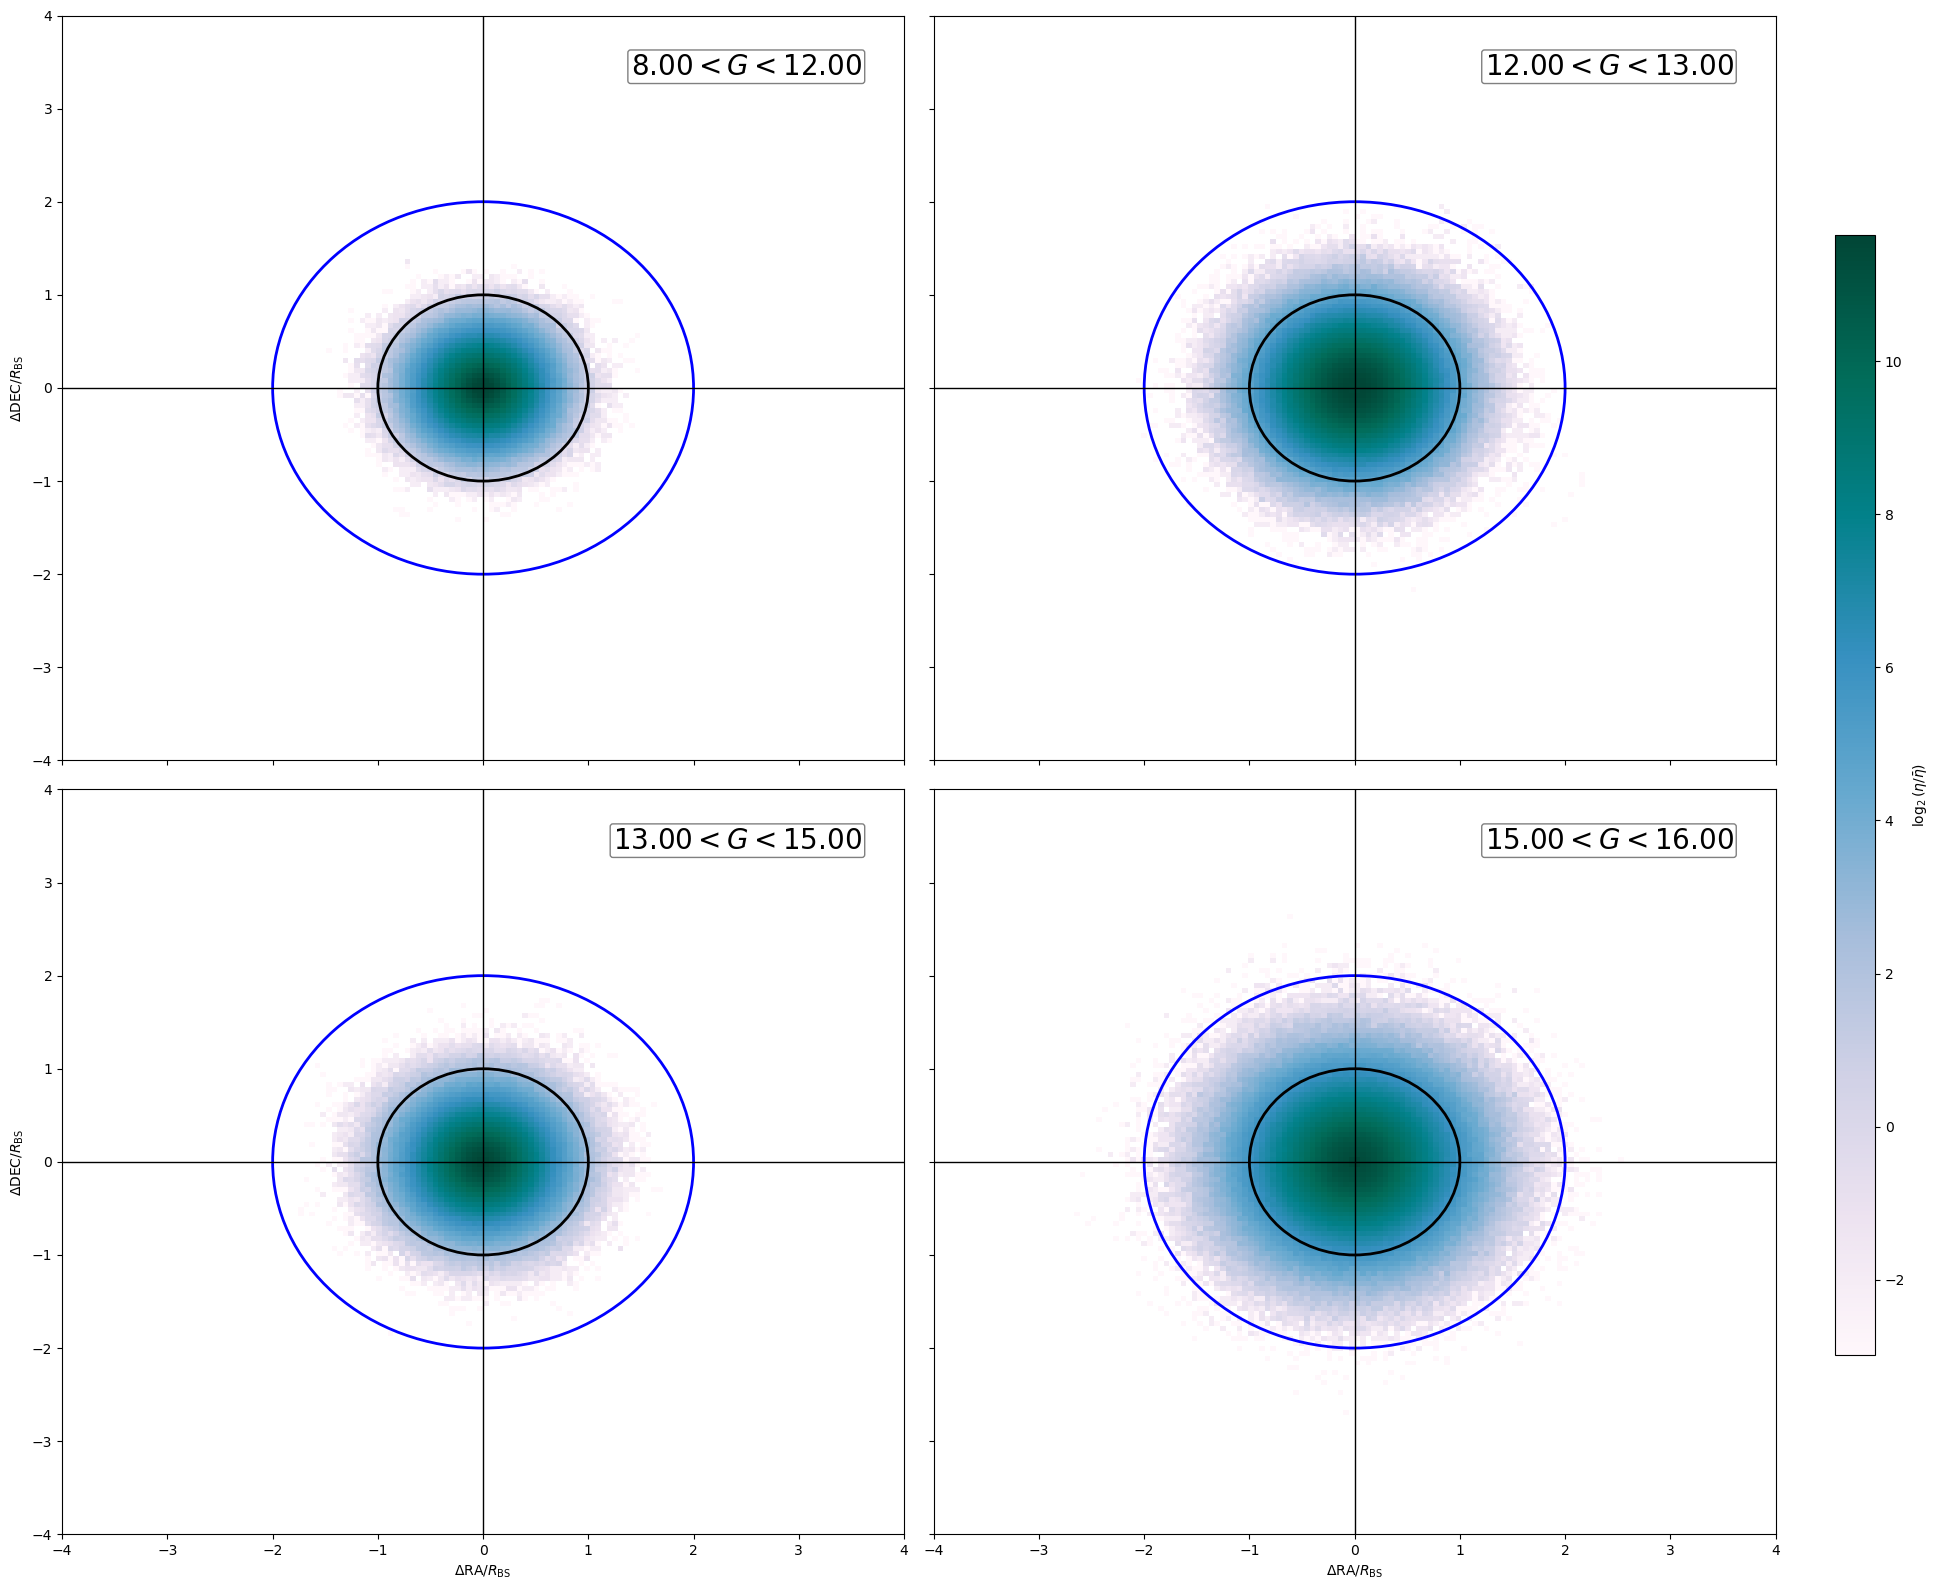

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16), sharex=True, sharey=True)

axes = axes.flatten()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    # stars = SkyCoord(ra=bright['RA'].values * u.deg,
    #                 dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=BG['RA'][sel_1].values * u.deg,
                    dec=BG['DEC'][sel_1].values * u.deg)

    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars  = SkyCoord(ra=bright['RA'].values*u.deg,
                      dec=bright['DEC'].values*u.deg)

    # match & compute offsets
    idx, _, _     = cats.match_to_catalog_sky(stars)
    ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
    ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
    dRAc = (ra_bg - ra_st)*np.cos(dec_st)
    dDec = dec_bg - dec_st

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[idx]
    R9_arcsec   = mask_radius_for_mag(mags_at_idx)
    x = dRAc * 3600.0 / R9_arcsec
    y = dDec * 3600.0 / R9_arcsec

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>1.1) & (R<4)
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn')


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    for rad, col in [(1,'k'), (2,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='-', lw=2, ec=col)
        ax.add_patch(circ)
    ax.text (0.95, 0.95, fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
             transform=ax.transAxes, fontsize=20, verticalalignment='top',
             horizontalalignment='right', bbox=dict(facecolor='white', alpha=1, edgecolor='gray', boxstyle='round,pad=0.1'))
    
    # ax.set_xlim(-4,4)
    # ax.set_ylim(-4,4)
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
plt.tight_layout(rect=[0,0,0.9,1])
plt.show()

